#algorithm

##Library

In [228]:
!pip install geopy
!pip install geopy timezonefinder
!pip install xlsxwriter
!pip install "git+https://github.com/oemof/feedinlib.git" -q
!pip install siphon
!pip install pvlib
!pip install NREL-PySAM
!pip install pyspark
import os
import requests
import xarray as xr
import csv
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib import pvsystem
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from feedinlib import WindPowerPlant
from feedinlib import get_power_plant_data
from feedinlib import era5
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql.functions import col, pandas_udf
from pyspark.sql.types import LongType
from requests import get

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [229]:
uid = 'your uid'
keypart = 'your keypart'
with open('/root/.cdsapirc','w') as keyFile:
      keyFile.write(
          'url: https://cds.climate.copernicus.eu/api/v2\n' + 
          f'key: {uid}:{keypart}'
    )
!cat '/root/.cdsapirc'

openenergy = get('https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows')

url: https://cds.climate.copernicus.eu/api/v2
key: 170535:8eda45d9-e9a2-468d-8154-732dd3a40435

##Solver

###Class

In [230]:
class multy:
  def __init__(self, city, start, end, Wind_power, PV_power):
    geolocator = Nominatim(user_agent="user")
    location = geolocator.geocode(city)
    tf = TimezoneFinder()
    loc = (location.latitude, location.longitude)
    timezone = tf.timezone_at(lng=location.longitude, lat=location.latitude)
    locations = [(location.latitude, location.longitude)]
    self.start = start
    self.end = end
    self.latitude = location.latitude
    self.longitude = location.longitude
    self.altitude = location.altitude
    self.Wind_power = Wind_power/1000
    self.PV_power = PV_power

    base_url_csv = "https://power.larc.nasa.gov//api/temporal/hourly/point?parameters=WS10M,ALLSKY_SFC_SW_DIFF,WS50M,T2M,PS,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,RH2M&community=SB&longitude={longitude}&latitude={latitude}&start={start}&end={end}&format=CSV"
    filename_template = "Weather.csv"
    for latitude, longitude in locations:
        api_request_url = base_url_csv.format(longitude=longitude, latitude=latitude, start=start, end=end)
        response = requests.get(url=api_request_url, verify=True, timeout=30.00)
        filename = filename_template.format(latitude=latitude, longitude=longitude)

    with open(os.path.split(filename)[1], 'wb') as f, \
            requests.get(api_request_url, stream=True) as r:
       for line in r.iter_lines():
            f.write(line+'\n'.encode())

  def weather(self):
    custom_datetime = lambda x: datetime.strptime(x, '%d %m %Y %H')
    df = pd.read_csv('/content/Weather.csv', skiprows=16, encoding='utf-8', parse_dates={ 'Date_Time': ['DY', 'MO', 'YEAR', 'HR'] }, date_parser=custom_datetime
                      )
    df.rename(columns = {'T2M':'Tamb','PS':'pressure', 'Date_Time': 'time','ALLSKY_SFC_SW_DWN': 'GHI', 'CLRSKY_SFC_SW_DWN': 'DHI', 'RH2M':'RH', 'ALLSKY_SFC_SW_DIFF': 'dni'}, inplace = True)
    df['temperature'] = df['Tamb'] + 273.15 
    df['pressure'] = df['pressure']*1000
    df.index.rename('time')
    return df

  def windpowerlib_weather(self):

    date1  = datetime.strptime(str(self.start), "%Y%m%d")
    date2 = date1 + timedelta(days=1)
    start_date, end_date = "{}-{}-{}".format(date1.year, date1.month, date1.day), "{}-{}-{}".format(date2.year, date2.month, date2.day)
    # установить переменную, установленную для загрузки
    variable = "windpowerlib"
    target_file = 'ERA5_pvlib.nc'
  
    ds = era5.get_era5_data_from_datespan_and_position(
      variable=variable,
      start_date=start_date, end_date=end_date, 
      latitude=self.latitude, longitude=self.longitude,
      target_file=target_file)
  
    era5_netcdf_filename = 'ERA5_pvlib.nc'
    ds = xr.open_dataset(era5_netcdf_filename)
    ds2 = era5.format_windpowerlib(ds)

    custom_datetime = lambda x: datetime.strptime(x, '%d %m %Y %H')
    df = pd.read_csv('/content/Weather.csv', skiprows=16, encoding='utf-8', parse_dates={ 'Date_Time': ['DY', 'MO', 'YEAR', 'HR'] }, date_parser=custom_datetime
                      )
    df.rename(columns = {'T2M':'temperature','PS':'pressure', 'Date_Time': 'time'}, inplace = True)
    df.drop(['ALLSKY_SFC_SW_DWN','CLRSKY_SFC_SW_DWN','ALLSKY_SFC_SW_DIFF','RH2M'], axis = 1 , inplace = True)
    df['temperature'] = df['temperature'] + 273.15 
    df['pressure'] = df['pressure']*1000
    df['roughness_length'] = round(ds2.iloc[1]['roughness_length'].item(),2)
    df['latitude'] = round(self.latitude,1)
    df['longitude'] = round(self.longitude,1)
    df = df.set_index(['time', 'latitude', 'longitude'])
    midx = pd.MultiIndex(
    levels=[
        ["wind_speed","pressure","temperature","roughness_length"],
        [0,2,10,50]
    ],
    codes=[
        [0,0,1,2,3],
        [2,3,0,1,0]
    ],
    names=["variable","height"],
    )
    df.columns = midx
    df.dropna(inplace=True)
    
    return df
    

  def PVlib_weather(self):
    custom_datetime = lambda x: datetime.strptime(x, '%d %m %Y %H')
    df = pd.read_csv('/content/Weather.csv', skiprows=16, encoding='utf-8', parse_dates={ 'Date_Time': ['DY', 'MO', 'YEAR', 'HR'] }, date_parser=custom_datetime
                      )
    df.rename(columns = {'T2M':'Tamb','PS':'pressure', 'Date_Time': 'time','ALLSKY_SFC_SW_DWN': 'GHI', 'CLRSKY_SFC_SW_DWN': 'DHI', 'RH2M':'RH', 'SZA' : 'zenith', 'ALLSKY_SFC_SW_DIFF': 'dni'}, inplace = True)
    df['temperature'] = df['Tamb'] + 273.15 
    df['pressure'] = df['pressure']*1000
    df.set_index(['time'], inplace= True)
    df.index.name = None
    df.drop(['temperature','WS50M','pressure','RH'], axis = 1 , inplace = True)
    df.rename(columns = {'WS10M': 'wind_speed', 'GHI': 'ghi', 'DHI': 'dhi', 'Tamb': 'temp_air'}, inplace = True)
    df = df.reindex(columns=['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed'])
    
    return df

  def Wind(self, windpowerlib_weather):
    df = pd.DataFrame(openenergy.json())
    df = df[['manufacturer', 'name','turbine_type', 'nominal_power', 'rotor_diameter', 'rotor_area', 'hub_height', 'has_power_curve', 'has_cp_curve']]
    df["has_power_curve"] = df["has_power_curve"].astype(int)
    df["has_cp_curve"] = df["has_cp_curve"].astype(int)
    df = df.loc[((df['has_power_curve'] == 1) &(df['has_cp_curve' ] == 1))]
    d = min(sorted(df['nominal_power']), key=lambda x: abs(self.Wind_power - x))
    df = df.loc[((df['nominal_power'] <= d)&((df['rotor_diameter'].astype(int)/2)<= 50))]
    df.reset_index(drop=True, inplace=True)
    turbine_data = {
          'turbine_type': df.at [0, 'turbine_type'],  #название турбины, как в библиотеке турбин
          'hub_height': 50  # in m
          }
    wind_turbine = WindPowerPlant(**turbine_data)
    feedin = wind_turbine.feedin(
         weather=windpowerlib_weather)
    result_wind = pd.DataFrame(feedin)
    result_wind = result_wind.reset_index( level = [1 , 2] )
    return result_wind

  def PV(self, PVlib_weather):
    sandia_mod_db = pvsystem.retrieve_sam('CECmod')
    PV_model = sandia_mod_db['ET_Solar_Industry_ET_P660255WWAC']
    invdb = pvsystem.retrieve_sam('CECInverter')
    d = min(sorted(invdb.T['Paco']), key=lambda x: abs(self.PV_power - x))
    Inverter = invdb.T[(invdb.T['Paco'] == d)]
    Inverter = Inverter.iloc[0]
    N = round(self.PV_power/PV_model.loc['PTC'])
    location = pvlib.location.Location(self.latitude, self.longitude, altitude=self.altitude)
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
    module_data = PV_model
    system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                 module_parameters=module_data,
                                 inverter_parameters=Inverter,
                                 temperature_model_parameters=temperature_model_parameters,
                                 modules_per_string=1, strings_per_inverter=round(self.PV_power/PV_model.loc['PTC']))
    mc = pvlib.modelchain.ModelChain(system, location, 
                                 aoi_model='no_loss', 
                                 spectral_model='no_loss',
                                 name='AssessingSolar_PV')
    mc.run_model(PVlib_weather)
    Solar_PVlib = pd.DataFrame()
    Solar_PVlib.index = mc.results.ac.index
    Solar_PVlib.index.name = 'time'
    Solar_PVlib['AC'] = mc.results.ac
    Solar_PVlib['DC'] = mc.results.dc['p_mp']
    return Solar_PVlib

  def total(self, PV:pd.Series, Wind: pd.Series):
    total = PV + Wind
    return total

  def BAT_charge(self, load:pd.Series, total:pd.Series)-> pd.Series:
    if load < total:
      return total - load
    else:
      return 0

  def DPS_without_bat(self, load:pd.Series, total:pd.Series)-> pd.Series:
    if load > total:
      return load - total
    else:
      return 0

  def SOC(self, df, BAT, DPS, max_SOC):
    if max_SOC == None:
      max_SOC = 650000
  #Доступная мощность заряда (В начальный момент времени  = 0 Вт)
    global SOC0
  #Максимальная мощность зарядки и разрядки аккумулятора, Вт 
    max_SOC = max_SOC
    for row in df.iterrows():
# Заряд Батареи (Происходит, когда энергия генерации превосходит нагрузку)
    # Если Энергия в Батареи > ДГУ
      if BAT > DPS:
      # Если заряд батареи меньше максимального
        if abs(SOC0) + BAT < max_SOC:
        # заряд принимаем равным:
          SOC0 = abs(SOC0) + BAT
        # Записывается положительно:
        return SOC0
      # Если заряд батареи больше или равен максимальному
        if abs(SOC0) + BAT >= max_SOC:
        # Заряд ограничивается на максимальном значении
          SOC0 = max_SOC
        # Записывается положительно:
        return SOC0
# Разряд батареи (Происходит, когда используется ДГУ, в целях уменьшения его использования) 
      # Если Энергия в Батареи < ДГУ
      if BAT < DPS:
      # Если заряд батареи меньше максимального
        if abs(SOC0) + BAT < max_SOC:
        # заряд принимаем равным:
          SOC0 = abs(SOC0) + BAT
      # Если  полученный заряд батареи > ДГУ
          if abs(SOC0) > DPS:
          # Заряд оказывается равным разности заряда батареи и ДГУ
            SOC0 = abs(SOC0) - DPS
          # Выводим отрицательное значение ДГУ, что символизирует "полное сглаживание" работы ДГУ
            return -DPS
          # Если заряд батареи оказывается меньше значению ДГУ
          if abs(SOC0) < DPS:
          # Выводим отричательное значение заряда, что символизирует полный разряд батареи
            return -SOC0
          # Соответственно последющий заряд батареи принимается равным нулю
        SOC0 = 0
      # Если заряд батареи больше или равен максимальному          
        if abs(SOC0) + BAT >= max_SOC:
        # Заряд ограничивается на максимальном значении
          SOC0 = max_SOC
        # Если заряд батареи больше значения ДГУ
          if abs(SOC0) > DPS:
          # Заряд оказывается равным разности заряда батареи и ДГУ
            SOC0 = abs(SOC0) - DPS
          # Выводим отрицательное значение ДГУ, что символизирует "полное сглаживание" работы ДГУ
            return -DPS
        # Если заряд батареи меньше значения ДГУ 
          if abs(SOC0) < DPS:
          # Выводим отрицательное значние ДГУ, что символизирует полный разряд батареи
            return -SOC0
        SOC0 = 0

# Убираем отрицательные значния 
  def POS(self, energy_in_BAT):
    if energy_in_BAT < 0:
      return energy_in_BAT
    else:
      return 0

  def conclusion(self, a: pd.Series, b: pd.Series) -> pd.Series:
      return print('Объем электроэнергии от ДЭС: ' + str(a.sum()) + ' Втч\n' +
                 'Максимальная мощность ДЭС: ' + str(a.max()) + ' Вт\n' +
                 'Объем профицита генерации ВИЭ: ' + str(b.sum()) + ' Втч')
 

###Generation 

In [231]:
illust = multy('Kemerovo', 20191231, 20210201, 1000000, 1000000)
#20191231, 20210201

In [232]:
illust.windpowerlib_weather()

variable                               wind_speed       pressure temperature  \
height                                         10    50       0           2    
time                latitude longitude                                         
2019-12-31 06:00:00 55.4     86.1            2.80  5.33   262.83     98800.0   
2019-12-31 07:00:00 55.4     86.1            3.12  5.65   263.02     98820.0   
2019-12-31 08:00:00 55.4     86.1            3.38  5.99   263.15     98840.0   
2019-12-31 09:00:00 55.4     86.1            3.73  6.25   263.40     98860.0   
2019-12-31 10:00:00 55.4     86.1            4.15  6.27   263.92     98880.0   
...                                           ...   ...      ...         ...   
2021-02-02 01:00:00 55.4     86.1            1.58  2.08   252.85     99650.0   
2021-02-02 02:00:00 55.4     86.1            2.27  3.18   251.03     99670.0   
2021-02-02 03:00:00 55.4     86.1            2.67  4.20   249.46     99700.0   
2021-02-02 04:00:00 55.4     86.1            2.88  5.03   248.18     99740.0   
2021-02-02 05:00:00 55.4     86.1            2.88  5.37   248.33     99770.0   

variable                               roughness_length  
height                                               0   
time                latitude longitude                   
2019-12-31 06:00:00 55.4     86.1                  0.24  
2019-12-31 07:00:00 55.4     86.1                  0.24  
2019-12-31 08:00:00 55.4     86.1                  0.24  
2019-12-31 09:00:00 55.4     86.1                  0.24  
2019-12-31 10:00:00 55.4     86.1                  0.24  
...                                                 ...  
2021-02-02 01:00:00 55.4     86.1                  0.24  
2021-02-02 02:00:00 55.4     86.1                  0.24  
2021-02-02 03:00:00 55.4     86.1                  0.24  
2021-02-02 04:00:00 55.4     86.1                  0.24  
2021-02-02 05:00:00 55.4     86.1                  0.24  

[9576 rows x 5 columns]

In [233]:
illust.PVlib_weather()

,ghi,dhi,dni,temp_air,wind_speed
2019-12-31 06:00:00,0.00,0.00,0.00,-10.32,2.80
2019-12-31 07:00:00,0.00,0.00,0.00,-10.13,3.12
2019-12-31 08:00:00,0.00,0.00,0.00,-10.00,3.38
2019-12-31 09:00:00,27.70,41.60,20.79,-9.75,3.73
2019-12-31 10:00:00,59.66,111.35,48.27,-9.23,4.15
...,...,...,...,...,...
2021-02-02 01:00:00,0.00,0.00,0.00,-20.30,1.58
2021-02-02 02:00:00,0.00,0.00,0.00,-22.12,2.27
2021-02-02 03:00:00,0.00,0.00,0.00,-23.69,2.67
2021-02-02 04:00:00,0.00,0.00,0.00,-24.97,2.88


In [234]:
illust.Wind(illust.windpowerlib_weather())

,latitude,longitude,feedin_power_plant
time,,,
2019-12-31 06:00:00,55.4,86.1,98120.0
2019-12-31 07:00:00,55.4,86.1,118600.0
2019-12-31 08:00:00,55.4,86.1,140360.0
2019-12-31 09:00:00,55.4,86.1,162750.0
2019-12-31 10:00:00,55.4,86.1,164490.0
...,...,...,...
2021-02-02 01:00:00,55.4,86.1,2960.0
2021-02-02 02:00:00,55.4,86.1,18320.0
2021-02-02 03:00:00,55.4,86.1,45800.0


In [235]:
df = pd.DataFrame()
df = illust.PV(illust.PVlib_weather())
df['Wind'] = illust.Wind(illust.windpowerlib_weather())['feedin_power_plant']
df

,AC,DC,Wind
time,,,
2019-12-31 06:00:00,-300.000000,-0.000000,98120.0
2019-12-31 07:00:00,-300.000000,0.000000,118600.0
2019-12-31 08:00:00,-300.000000,0.000000,140360.0
2019-12-31 09:00:00,54448.370841,62092.893547,162750.0
2019-12-31 10:00:00,210990.768467,223029.052564,164490.0
...,...,...,...
2021-02-02 01:00:00,-300.000000,0.000000,2960.0
2021-02-02 02:00:00,-300.000000,-0.000000,18320.0
2021-02-02 03:00:00,-300.000000,0.000000,45800.0


In [236]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['AC'], name='AC power PVlib, Вт',
                         line=dict(color='Green', width=3),  textposition='top center',textfont=dict(
        color='black',
        size=32,
        family='Times New Roman')))

fig.add_trace(go.Scatter(x=df.index, y=df['Wind'], name='Мощность ветряной станции, Вт',
                         line=dict(color='#4169E1', width=3), textposition='top center',textfont=dict(
        color='black',
        size=32,
        family='Times New Roman')))


fig.update_layout(
                   xaxis_title='<b>Время<b>',
                   yaxis_title='<b>Мощность, Вт<b>',
    title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="black", legend_title_font_family = "Times New Roman" , plot_bgcolor='rgba(245,40,145,0)', legend_font_size=16, legend_font_color='black')
fig.update_xaxes(tickfont=dict(color='black', size=16))
fig.update_yaxes(tickfont=dict(color='black', size=16))
fig.update_xaxes(title_font=dict(color='black', size=25))
fig.update_yaxes(title_font=dict(color='black', size=25))
fig.update_layout(
       autosize=False,
    xaxis_tickformat = '%d %b %Y', 
    width=1250,
    height=350,legend=dict( yanchor="top",xanchor="right"))
    
  
fig.show()

###Load input

In [237]:
df = df.query("'2020-01-01 01:00:00' <= time < '2020-01-09 08:00:00'")

In [238]:
total_energy = illust.total(df['AC'],df['Wind'])

In [239]:
mine = pd.read_csv('/content/mine_load.csv', sep = ';', decimal="-" ,encoding='utf-8',
                parse_dates={'time': ['Date', 'Time']})
mine['time'] = mine['time'].str.replace('.','/')
mine['time'] = df.index
mine = mine.set_index('time')
mine['Power'] = mine['Power'].astype(np.float64)
mine['Power'] = mine['Power'].apply(lambda x: x*10**6)
scaler = MinMaxScaler(feature_range = (0, 1))
mine[['Power']] = scaler.fit_transform(mine[['Power']])
mine['Power'] = mine['Power'].apply(lambda x: x*10**6)

<ipython-input-239-664a4f47f2ba>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [240]:
df['total'] = total_energy
df['load'] = mine['Power']
df

<ipython-input-240-69c5390dc9e0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-69c5390dc9e0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AC,DC,Wind,total,load
time,,,,,
2020-01-01 01:00:00,-300.0,0.0,190590.0,190290.0,204009.433962
2020-01-01 02:00:00,-300.0,0.0,189720.0,189420.0,56603.773585
2020-01-01 03:00:00,-300.0,-0.0,168840.0,168540.0,344929.245283
2020-01-01 04:00:00,-300.0,0.0,185370.0,185070.0,525943.396226
2020-01-01 05:00:00,-300.0,0.0,200160.0,199860.0,73702.830189
...,...,...,...,...,...
2020-01-09 03:00:00,-300.0,0.0,60230.0,59930.0,531250.000000
2020-01-09 04:00:00,-300.0,0.0,69200.0,68900.0,624410.377358
2020-01-09 05:00:00,-300.0,0.0,78280.0,77980.0,787146.226415


###BATtary and Diesel Power Station

In [241]:
df['BAT_charge'] = df.apply(lambda x: illust.BAT_charge(x['load'] ,x['total']), axis = 1)
df['DPS_without_bat'] = df.apply(lambda x: illust.DPS_without_bat(x['load'] ,x['total']), axis = 1)
df

<ipython-input-241-e642d474eb50>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-241-e642d474eb50>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AC,DC,Wind,total,load,BAT_charge,DPS_without_bat
time,,,,,,,
2020-01-01 01:00:00,-300.0,0.0,190590.0,190290.0,204009.433962,0.000000,13719.433962
2020-01-01 02:00:00,-300.0,0.0,189720.0,189420.0,56603.773585,132816.226415,0.000000
2020-01-01 03:00:00,-300.0,-0.0,168840.0,168540.0,344929.245283,0.000000,176389.245283
2020-01-01 04:00:00,-300.0,0.0,185370.0,185070.0,525943.396226,0.000000,340873.396226
2020-01-01 05:00:00,-300.0,0.0,200160.0,199860.0,73702.830189,126157.169811,0.000000
...,...,...,...,...,...,...,...
2020-01-09 03:00:00,-300.0,0.0,60230.0,59930.0,531250.000000,0.000000,471320.000000
2020-01-09 04:00:00,-300.0,0.0,69200.0,68900.0,624410.377358,0.000000,555510.377358
2020-01-09 05:00:00,-300.0,0.0,78280.0,77980.0,787146.226415,0.000000,709166.226415


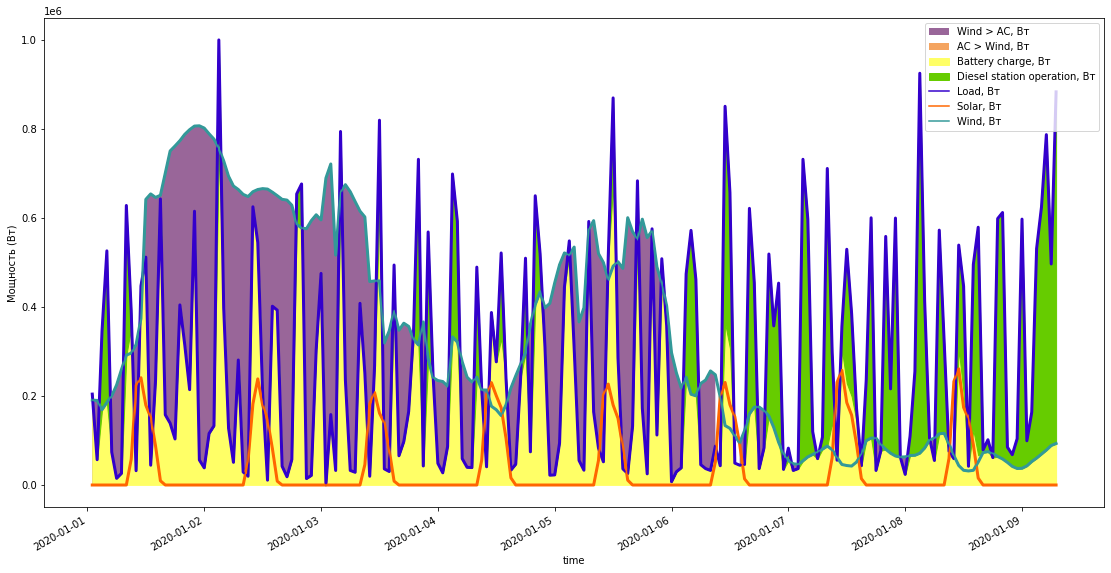

In [242]:
fig, ax = plt.subplots()

ax.plot(df.index, df['load'], color = '#3300CC', linewidth = 3)
ax.plot(df.index, df['AC'], color = '#FF6600', linewidth = 3)
ax.plot(df.index, df['Wind'], color = '#339999', linewidth = 3)

plt.fill_between(df.index, df['Wind'], 0,
                where= (df['Wind'] > df['AC']),
                facecolor='#996699', label='Wind > AC, Вт')
plt.fill_between(df.index, df['AC'], 0,
                where= (df['Wind'] < df['AC']),
                facecolor='#F4A460', label='AC > Wind, Вт')

SelfConsumption = np.minimum(df['total'],df['load'])


plt.fill_between(df.index,SelfConsumption[df.index],0,color='#FFFF66',label='Battery charge, Вт')
plt.fill_between(df.index,SelfConsumption[df.index],df['load'],color='#66CC00',label='Diesel station operation, Вт')
plt.legend()

fig.set_figwidth(19)    #  ширина и
fig.set_figheight(10)    #  высота "Figure"

df['load'].plot(legend=True,color='#3300CC',label='Load, Вт')
df['AC'].plot(legend=True,color='#FF6600',label='Solar, Вт')
df['Wind'].plot(legend=True,color='#339999',label='Wind, Вт')
plt.ylabel('Мощность (Вт)')


plt.show()

In [243]:
# Начальное значение Батареи
SOC0 = 0
df['energy_in_BAT'] = df.apply(lambda x: illust.SOC(df, x['BAT_charge'], x['DPS_without_bat'], 650000), axis = 1)
df['energy_in_BAT'] = df.apply(lambda x: illust.POS(x['energy_in_BAT']), axis = 1)
df

<ipython-input-243-decd96aa72b2>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-243-decd96aa72b2>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AC,DC,Wind,total,load,BAT_charge,DPS_without_bat,energy_in_BAT
time,,,,,,,,
2020-01-01 01:00:00,-300.0,0.0,190590.0,190290.0,204009.433962,0.000000,13719.433962,0.000000
2020-01-01 02:00:00,-300.0,0.0,189720.0,189420.0,56603.773585,132816.226415,0.000000,0.000000
2020-01-01 03:00:00,-300.0,-0.0,168840.0,168540.0,344929.245283,0.000000,176389.245283,-132816.226415
2020-01-01 04:00:00,-300.0,0.0,185370.0,185070.0,525943.396226,0.000000,340873.396226,-132816.226415
2020-01-01 05:00:00,-300.0,0.0,200160.0,199860.0,73702.830189,126157.169811,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2020-01-09 03:00:00,-300.0,0.0,60230.0,59930.0,531250.000000,0.000000,471320.000000,-89265.984750
2020-01-09 04:00:00,-300.0,0.0,69200.0,68900.0,624410.377358,0.000000,555510.377358,-89265.984750
2020-01-09 05:00:00,-300.0,0.0,78280.0,77980.0,787146.226415,0.000000,709166.226415,-89265.984750


In [244]:
df['DPS'] = df['DPS_without_bat'] + df['energy_in_BAT']
df

<ipython-input-244-639e4b574436>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AC,DC,Wind,total,load,BAT_charge,DPS_without_bat,energy_in_BAT,DPS
time,,,,,,,,,
2020-01-01 01:00:00,-300.0,0.0,190590.0,190290.0,204009.433962,0.000000,13719.433962,0.000000,13719.433962
2020-01-01 02:00:00,-300.0,0.0,189720.0,189420.0,56603.773585,132816.226415,0.000000,0.000000,0.000000
2020-01-01 03:00:00,-300.0,-0.0,168840.0,168540.0,344929.245283,0.000000,176389.245283,-132816.226415,43573.018868
2020-01-01 04:00:00,-300.0,0.0,185370.0,185070.0,525943.396226,0.000000,340873.396226,-132816.226415,208057.169811
2020-01-01 05:00:00,-300.0,0.0,200160.0,199860.0,73702.830189,126157.169811,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2020-01-09 03:00:00,-300.0,0.0,60230.0,59930.0,531250.000000,0.000000,471320.000000,-89265.984750,382054.015250
2020-01-09 04:00:00,-300.0,0.0,69200.0,68900.0,624410.377358,0.000000,555510.377358,-89265.984750,466244.392609
2020-01-09 05:00:00,-300.0,0.0,78280.0,77980.0,787146.226415,0.000000,709166.226415,-89265.984750,619900.241665


In [245]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['DPS'], name='DPS, Вт',
                         line=dict(color='#4169E1', width=3), textposition='top center',textfont=dict(
        color='black',
        size=32,
        family='Times New Roman')))
fig.add_trace(go.Scatter(x=df.index, y=df['BAT_charge'], name='BAT_charge, Вт',
                         line=dict(color='Green', width=3), textposition='top center',textfont=dict(
        color='black',
        size=32,
        family='Times New Roman')))

fig.update_layout(
                   xaxis_title='<b>Время<b>',
                   yaxis_title='<b>Мощность, Вт<b>',
    title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="black", legend_title_font_family = "Times New Roman" , plot_bgcolor='rgba(245,40,145,0)', legend_font_size=16, legend_font_color='black')
fig.update_xaxes(tickfont=dict(color='black', size=16))
fig.update_yaxes(tickfont=dict(color='black', size=16))
fig.update_xaxes(title_font=dict(color='black', size=25))
fig.update_yaxes(title_font=dict(color='black', size=25))
fig.update_layout(
       autosize=False,
    xaxis_tickformat = '%d %b %Y', 
    width=1250,
    height=700,legend=dict( yanchor="top",xanchor="left"))
    
  
fig.show()

####Result

In [246]:
illust.conclusion(df['DPS'], df['BAT_charge'])

Объем электроэнергии от ДЭС: 9544532.6868202 Втч
Максимальная мощность ДЭС: 820597.2366241359 Вт
Объем профицита генерации ВИЭ: 38590784.41892856 Втч
